In [1]:
import itertools as itt
import pathlib as pl
from configparser import ConfigParser
from math import factorial
from collections import defaultdict

from tqdm import tqdm
import joblib as jl
import numpy as np
import scipy.stats as sst
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from IPython.display import Image
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA

from src.root_path import config_path, root_path
from src.utils.tools import get_quantile_means
from src.data.rasters import load_site_formated_raster
from src.visualization.palette import ColorList, TENCOLOR
from src.visualization.interactive import plot_raw_pair
from src.visualization.fancy_plots import squarefy

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2022-07-26 120133.log


# trying to compare firing rates and T-scores
loads the two requirede dataframes: one containing T-score integrals across time intervals</br>
The other containing mean firing rastes also at different  time intervals, both for the probe and context

In [2]:
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220719_chunked_amplitude_DF'

metrics = ['integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D',
           # 'mass_center', 'last_bin',
           ]
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC'")
DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr', 'analysis'], inplace=True)

fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220719_ctx_prb_firerates' # new 20hz
DF_fr = jl.load(fr_DF_file)

In [3]:
# Calculate delta firing rate for pairs of contexts
DF_dfr = DF_fr.query("context != 'mean'"
                  ).pivot_table(index=['id', 'site', 'chunk', 'probe', 'part'], columns=['context'],
                                values='value', aggfunc='first')

n_comb = int(factorial(DF_dfr.shape[1]) /
                     (2 * factorial(DF_dfr.shape[1]-2)))
ctx_pair_R = np.full((DF_dfr.shape[0], n_comb), np.nan)
new_cols = list()
for pr_idx,(c0, c1) in enumerate(itt.combinations(DF_dfr.columns, r=2)):
    new_cols.append(f'{c0:02}_{c1:02}')
    # ctx_pair_R[:, pr_idx] = np.abs(DF_dfr.values[:,c0] - DF_dfr.values[:,c1])
    ctx_pair_R[:, pr_idx] = DF_dfr.values[:,c0] - DF_dfr.values[:,c1]

DF_dfr = pd.DataFrame(index=DF_dfr.index, columns=new_cols, data=ctx_pair_R
                      ).melt(var_name='context_pair', value_name='delta_fr', ignore_index=False).dropna().reset_index()
print(DF_dfr.head())
print(DF_dfr.shape)

             id     site chunk  probe     part context_pair  delta_fr
0  AMT020a-02-1  AMT020a     A      1  context        00_01 -0.469999
1  AMT020a-02-1  AMT020a     A      1    probe        00_01  0.023500
2  AMT020a-02-1  AMT020a     A      2  context        00_01 -0.387749
3  AMT020a-02-1  AMT020a     A      2    probe        00_01  0.141000
4  AMT020a-02-1  AMT020a     A      3  context        00_01 -0.469999
(5025400, 7)


In [4]:
#saves a filtering dataframe containing only significan instancese
signifDF = DF.query("metric == 'integral' and value > 0").loc[:, ['id','context_pair','probe']]

In [65]:
fig_folder = root_path / 'reports' / 'figures' / 'fr_regressions'
fig_folder.mkdir(parents=True, exist_ok=True)

# Neuron wise regression
T-scores at different chunks as a function of delta fr at diferent chunks.
The weights i.e. slope of the regressions are calculated and saved for every neuron.
The weights are the ploted as boxplots

I cannot see any significant trend in this quantification.

In [5]:
# simple neuron regression
# right side contains delta firing rates
right = DF_dfr.query("part == 'context'").pivot_table(
    index=['id', 'site', 'probe', 'context_pair'],columns='chunk', values='delta_fr'
).reset_index()

reg_df = list()
for regressand in ['integral_A', 'integral_B', 'integral_C', 'integral_D']:
    toregress = pd.merge(left=DF.query(f"metric == '{regressand}' and value > 0 and value < 10000"),
                          right=right, on=['id', 'site', 'probe', 'context_pair'])

    for neuron in toregress.id.unique():
        neu_df = toregress.query(f"id == '{neuron}'")

        # defines model and fits
        X = neu_df.loc[:,['A', 'B', 'C', 'D']].astype(float)
        X = sm.add_constant(X)
        Y = neu_df['value'].astype(float)
        model = sm.OLS(Y, X, hasconst=True)
        res = model.fit()

        # parses out regression weights i.e. slopes
        try:
            weights = res.params.drop(index='const') # sometimes there is no parameters when the regression fails
        except:
            continue
        weights.name='weigths'
        CI = res.conf_int().drop(index='const').rename(columns={0:'lower_ci',1:'upper_ci'})

        # compiles in a df with extra info about results source
        d = pd.concat([weights, CI], axis=1)
        d['id'] = neuron
        d['regresor'] = 'self'
        d['regressand'] = regressand

        reg_df.append(d)

reg_df = pd.concat(reg_df)

/auto/users/mateo/miniconda3/envs/cpa_tf/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/auto/users/mateo/miniconda3/envs/cpa_tf/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/auto/users/mateo/miniconda3/envs/cpa_tf/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/auto/users/mateo/miniconda3/envs/cpa_tf/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/auto/users/mateo/miniconda3/envs/cpa_tf/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:

  chunk     weigths     lower_ci     upper_ci            id regresor  \
0     A   94.578099  -209.829088   398.985286  AMT029a-35-1     self   
1     B  733.688426 -1021.088755  2488.465608  AMT029a-35-1     self   
2     C -764.658080 -2303.987342   774.671181  AMT029a-35-1     self   
3     D -698.971930 -3108.262205  1710.318345  AMT029a-35-1     self   
4     A  468.311463  -969.965571  1906.588497  AMT029a-43-1     self   

   regressand  
0  integral_A  
1  integral_A  
2  integral_A  
3  integral_A  
4  integral_A  


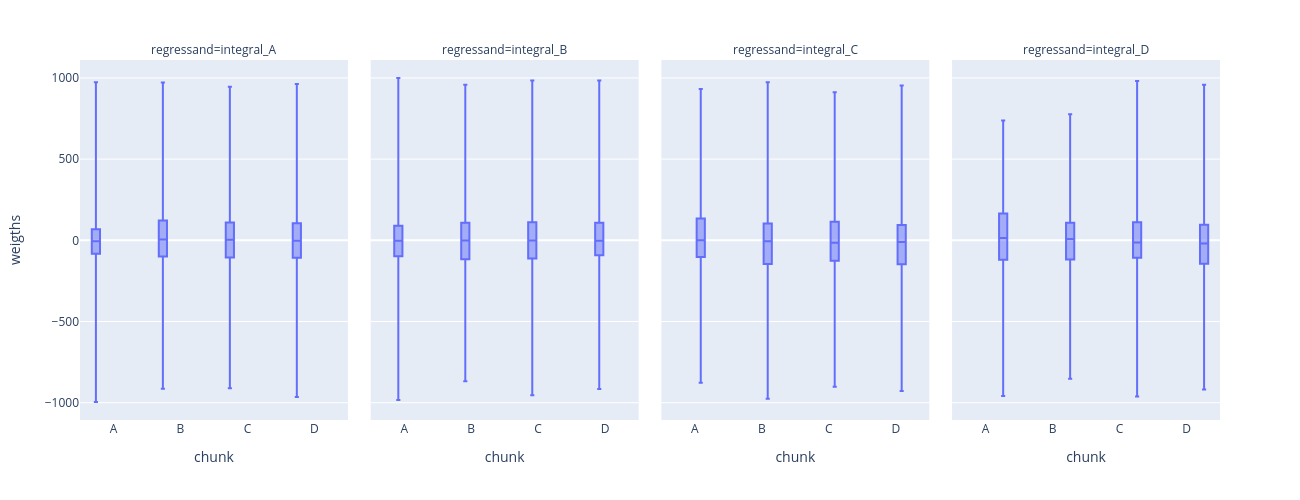

In [6]:
toplot = reg_df.reset_index().rename(columns={'index':'chunk'}).query('weigths < 1000 and weigths >-1000')
print(toplot.head())

fig = px.box(toplot.reset_index(), x='chunk', y='weigths', points=False, facet_col='regressand')
# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=500)
Image(img_bytes)

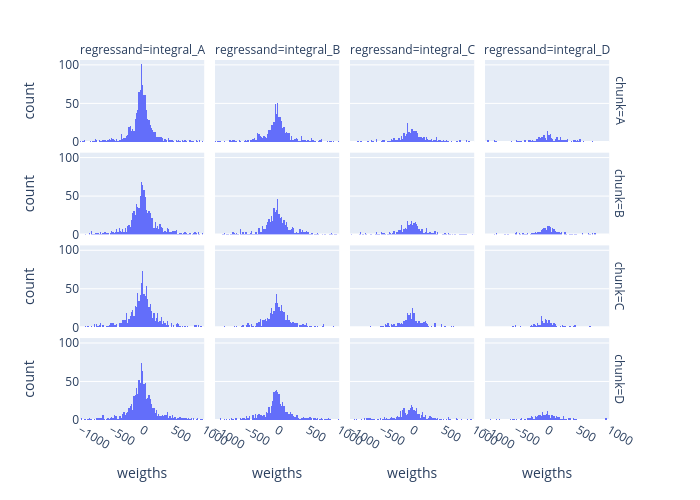

In [7]:
# Same data as above, the different bars are now different rows
fig = px.histogram(toplot.reset_index(), x='weigths', facet_col='regressand', facet_row='chunk')
img_bytes = fig.to_image(format="png")
Image(img_bytes)

# regress T-score to delta fr
This is reviciting the old, buggy firing rate done ages ago.
Regresse the T-Score integral at different time chunks as a funciton of the delta firing rate at all context time chunks
the regression is done simultaneously for all four context time chunks.

In [8]:
fr_Ts_reg_panels = defaultdict(list)

left = DF_dfr.query("part == 'context'")
res_dict = dict()
subtitles = dict()

ctx_chunks = ['A','B','C','D']
prb_chunks= ['integral_A','integral_B','integral_C','integral_D']
for pc, prb_chunk in enumerate(['integral_A','integral_B','integral_C','integral_D']):

    right = DF.query(f"metric == '{prb_chunk}' and value > 0 and value < 10000").pivot_table(
        index=['id', 'probe', 'context_pair'], columns='metric', values='value'
    ).reset_index()

    toregress = pd.merge(left, right, on=['id', 'probe', 'context_pair'], validate="m:1"
                         ).pivot_table(index=['id', 'context_pair', 'probe', prb_chunk],
                                       columns=['chunk'],
                                       values='delta_fr', aggfunc='first').reset_index().copy()

    # run regression
    X = toregress.loc[:,['A', 'B', 'C', 'D']].astype(float)
    X = sm.add_constant(X)
    Y = toregress[prb_chunk].astype(float)
    model = sm.OLS(Y, X, hasconst=True)
    res = model.fit()
    res_dict[prb_chunk] = res


    for cc, ctx_chunk in enumerate(ctx_chunks):

        color = ColorList[cc%len(ColorList)]

        x = toregress[ctx_chunk].values
        y = toregress[prb_chunk].values

        # decimated scatterplot
        xm, ym = get_quantile_means(x=x, y=y, n_quantiles=1000)
        scatter = go.Scatter(x=xm, y=ym, mode='markers',
                                 marker=dict(opacity=1,
                                             color=color,
                                             size=1),
                                 line_width=2,
                                 showlegend=False)

        fr_Ts_reg_panels[f'{pc+1}_{cc+1}'].append(scatter)
        # fig.add_trace(scatter, row=pc+1, col=cc+1)

        # regression line
        xr = np.asarray([np.nanmin(xm), np.nanmax(xm)]).squeeze().astype(float)
        yr = res.params['const'] + xr * res.params[ctx_chunk]
        reg_line = go.Scatter(x=xr, y=yr, mode='lines',
                                 line=dict(width=1,
                                           color=color,
                                           dash='dot'),
                                 showlegend=False)

        fr_Ts_reg_panels[f'{pc+1}_{cc+1}'].append(reg_line)
        # fig.add_trace(reg_line, row=pc+1, col=cc+1)

        # saves subplot title
        name = f"{ctx_chunk}_{prb_chunk.split('_')[1]}<br>" \
               f"b={res.params['const']:.2f}, m={res.params[ctx_chunk]:.2f}<br>" \
               f"r2={res.rsquared:.2f}, p={res.pvalues[ctx_chunk]:.2f}"
        subtitles[f"{ctx_chunk}_{prb_chunk.split('_')[1]}"] = name

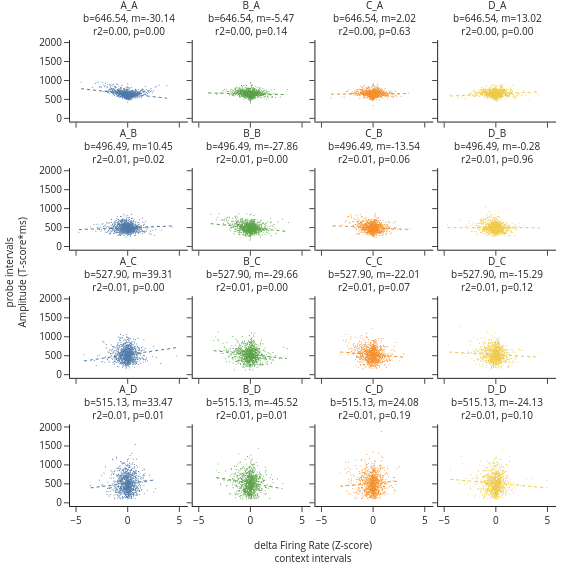

In [9]:
# define the layout
x_title = 'delta Firing Rate (Z-score)<br>context intervals'
y_title = 'probe intervals<br>Amplitude (T-score*ms)'
fig = make_subplots(4, 4, shared_xaxes='all', shared_yaxes='all',
                    vertical_spacing=0.1, horizontal_spacing=0.01,
                    subplot_titles=[f"{CC}_{PC}" for PC, CC in itt.product(['A','B','C','D'], repeat=2)],
                    x_title=x_title,
                    y_title=y_title,
                    )

pwidth=round(96 * 6)
pheight=round(96 * 6)
fig.update_layout(template='simple_white',
                  width=pwidth, height=pheight,
                  margin=dict(l=70, r=20, t=40, b=70),
                  showlegend=False,
                  font_size=10,
                  )
fig.update_xaxes(title_standoff=0)
fig.update_yaxes(title_standoff=0)


# replaces the panel titles with more information
# add self mapping to the anotations contituting x and y titles
subtitles[x_title] = x_title
subtitles[y_title] = y_title

fig.for_each_annotation(lambda a: a.update(text = subtitles[a.text], font_size=10))

# add the pannels

for loc, pan in fr_Ts_reg_panels.items():
    rr, cc = [int(s) for s in loc.split('_')]
    fig.add_traces(pan, rows=[rr]*len(pan), cols=[cc]*len(pan))


img_bytes = fig.to_image(format="png", width=pwidth, height=pheight)
Image(img_bytes)

In [66]:
# filename = fig_folder / 'fr_Ts_regression'
# fig.write_image(filename.with_suffix('.png'))
# fig.write_image(filename.with_suffix('.svg'))
# print('done saving figures')

PosixPath('/auto/users/mateo/code/context_probe_analysis/reports/figures/fr_regressions')

### slope plots
somewhat more digestible summar of previous plot??

In [11]:
# organize regression results in dataframe
df = list()
for prb_chunk, regression in res_dict.items():
    # parameters, includes one bias and 4 weithgs
    ser = regression.params
    ser.name = prb_chunk
    df.append(ser)

df = pd.DataFrame(df).reset_index().rename(columns={'index':'prb_chunk'})
df['prb_chunk'] = df.prb_chunk.apply(lambda x: x.split('_')[1])

chunks = ['A', 'B', 'C', 'D']
molten = df.reset_index().melt(id_vars='prb_chunk',
                               value_vars=chunks, var_name='ctx_chunk', value_name='slope')

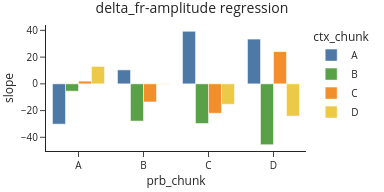

In [12]:

colormap = {ck:ColorList[chunks.index(ck)%len(ColorList)] for ck in chunks}
fig = px.bar(data_frame=molten, x='prb_chunk', y='slope', color='ctx_chunk',color_discrete_map=colormap,
       barmode='group')

pwidth=round(96 * 4)
pheight=round(96 * 2)
fig.update_layout(template='simple_white',
                  width=pwidth, height=pheight,
                  margin=dict(l=20, r=20, t=25, b=20),
                  showlegend=True,
                  title=dict(text='delta_fr-amplitude regression',
                             x=0.5),
                  font_size=10,
                  )
fig.update_xaxes(title_standoff=0)
fig.update_yaxes(title_standoff=0)

img_bytes = fig.to_image(format="png", width=pwidth, height=pheight)
Image(img_bytes)

In [13]:
# filename = fig_folder / 'fr_Ts_regression_slopes'
# fig.write_image(filename.with_suffix('.png'))
# fig.write_image(filename.with_suffix('.svg'))
# print('done saving figures')

# Regress delta fr to itself!

In [14]:
fr_fr_reg_panels = defaultdict(list)

left = DF_dfr.query("part == 'context'")

# you can also filte to only include singificant instances
left = pd.merge(left=left, right=signifDF, on=['id','probe', 'context_pair'], validate="m:1")

res_dict = dict()
subtitles = dict()
# for pc, prb_chunk in enumerate(['A','B','C','D']):
for pc, prb_chunk in enumerate(['A']):
    right = DF_dfr.query(f"part == 'probe' and chunk == '{prb_chunk}'")

    toregress = pd.merge(left, right, on=['id', 'probe', 'context_pair'], validate="m:1"
                         ).pivot_table(index=['id', 'context_pair', 'probe', 'delta_fr_y'],
                                       columns=['chunk_x'],
                                       values='delta_fr_x', aggfunc='first').reset_index().copy()

    # run regression
    X = toregress.loc[:,['A', 'B', 'C', 'D']].astype(float)
    X = sm.add_constant(X)

    Y = toregress['delta_fr_y'].astype(float)
    model = sm.OLS(Y, X, hasconst=True)
    res = model.fit()
    res_dict[prb_chunk] = res


    for cc, ctx_chunk in enumerate(['A','B','C','D']):

        color = ColorList[cc%len(ColorList)]

        x = toregress[ctx_chunk].values
        y = toregress['delta_fr_y'].values

        # decimated scatterplot
        # xm, ym = get_quantile_means(x=x, y=y, n_quantiles=500)

        decimator = np.random.choice(x.size, 5000, replace=False)
        xm, ym = x[decimator], y[decimator]

        scatter = go.Scatter(x=xm, y=ym, mode='markers',
                                 marker=dict(opacity=0.3,
                                             color=color,
                                             size=3),
                                 opacity=0.9,
                                 showlegend=False)

        fr_fr_reg_panels[f'{pc+1}_{cc+1}'].append(scatter)

        # regression line
        xr = np.asarray([np.nanmin(xm), np.nanmax(xm)]).squeeze().astype(float)
        yr = res.params['const'] + xr * res.params[ctx_chunk]
        reg_line = go.Scatter(x=xr, y=yr, mode='lines',
                                 line=dict(width=2,
                                           color=color,
                                           dash='dot'),
                                 showlegend=False)

        fr_fr_reg_panels[f'{pc+1}_{cc+1}'].append(reg_line)

        # saves subplot title
        name = f"{ctx_chunk}_{prb_chunk}<br>" \
               f"b={res.params['const']:.2f}, m={res.params[ctx_chunk]:.2f}<br>" \
               f"r2={res.rsquared:.2f}, p={res.pvalues[ctx_chunk]:.2f}"
        subtitles[f'{ctx_chunk}_{prb_chunk}'] = name


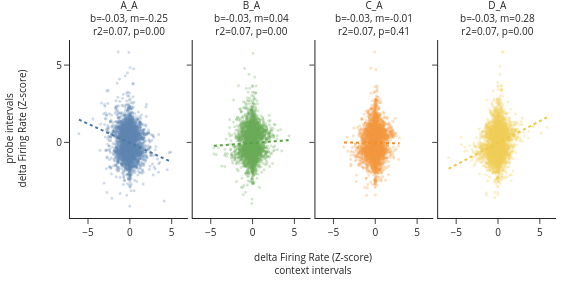

In [15]:
# define the layout
x_title = 'delta Firing Rate (Z-score)<br>context intervals'
y_title = 'probe intervals<br>delta Firing Rate (Z-score)'
fig = make_subplots(1, 4, shared_xaxes='all', shared_yaxes='all',
                    vertical_spacing=0.1, horizontal_spacing=0.01,
                    subplot_titles=[f"{CC}_{PC}" for PC, CC in itt.product(['A','B','C','D'], repeat=2)],
                    x_title=x_title,
                    y_title=y_title,
                    )

pwidth=round(96 * 6)
pheight=round(96 * 3)
fig.update_layout(template='simple_white',
                  width=pwidth, height=pheight,
                  margin=dict(l=70, r=20, t=40, b=70),
                  showlegend=False,
                  font_size=12,
                  )
fig.update_xaxes(title_standoff=0)
fig.update_yaxes(title_standoff=0)

# replaces the panel titles with more information
# add self mapping to the anotations contituting x and y titles
subtitles[x_title] = x_title
subtitles[y_title] = y_title

fig.for_each_annotation(lambda a: a.update(text = subtitles[a.text], font_size=10))

# add the pannels

for loc, pan in fr_fr_reg_panels.items():
    rr, cc = [int(s) for s in loc.split('_')]
    fig.add_traces(pan, rows=[rr]*len(pan), cols=[cc]*len(pan))


img_bytes = fig.to_image(format="png", width=pwidth, height=pheight)
Image(img_bytes)

In [16]:
filename = fig_folder / 'fr_fr_regression'
fig.write_image(filename.with_suffix('.png'))
fig.write_image(filename.with_suffix('.svg'))
print('done saving figures')

done saving figures


### slope plots
somewhat more digestible summar of previous plot??

In [17]:
# organize regression results in dataframe
df = list()
for prb_chunk, regression in res_dict.items():
    # parameters, includes one bias and 4 weithgs
    ser = regression.params
    ser.name = prb_chunk
    df.append(ser)

df = pd.DataFrame(df).reset_index().rename(columns={'index':'prb_chunk'})
chunks = ['A', 'B', 'C', 'D']
molten = df.reset_index().melt(id_vars='prb_chunk',
                               value_vars=chunks, var_name='ctx_chunk', value_name='slope')

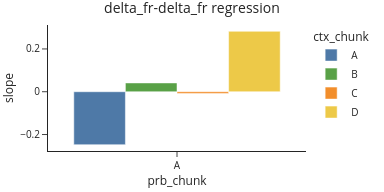

In [18]:

colormap = {ck:ColorList[chunks.index(ck)%len(ColorList)] for ck in chunks}
fig = px.bar(data_frame=molten, x='prb_chunk', y='slope', color='ctx_chunk',color_discrete_map=colormap,
       barmode='group')

pwidth=round(96 * 4)
pheight=round(96 * 2)
fig.update_layout(template='simple_white',
                  width=pwidth, height=pheight,
                  margin=dict(l=20, r=20, t=25, b=20),
                  showlegend=True,
                  title=dict(text='delta_fr-delta_fr regression',
                             x=0.5),
                  font_size=10,
                  )
fig.update_xaxes(title_standoff=0)
fig.update_yaxes(title_standoff=0)
img_bytes = fig.to_image(format="png", width=pwidth, height=pheight)
Image(img_bytes)

In [19]:
# # lets not overwrite the full bar plot for all time points in the probe
# filename = fig_folder / 'fr_fr_regression_slopes'
# fig.write_image(filename.with_suffix('.png'))
# fig.write_image(filename.with_suffix('.svg'))
# print('done saving figures')

# plot examples
Mean PSTHs for:
1. possitive correlation of ctx_D vs prb_A
2. negative correlation of ctx_A vs prb_A

the PSHTs are sorted by the flipped delta fr, where the probe delta fr is always possitive

perhaps some example psths??

In [69]:
def pool_top_PSTH(top_df, top_n, raster_fs=20):
    pooled_PSHTs = np.empty([top_n, 2, 2 * raster_fs])  # array of PSTHs with shape, nPSTHs x Ctx x Time
    for rr, row in top_df.head(top_n).iterrows():
        cellid = row.id
        ctx0_idx, ctx1_idx = [int(s) for s in row.context_pair.split('_')]
        prb_idx = row.probe - 1

        site_raster, goodcells = load_site_formated_raster(cellid[:7], part='all',
                                                           smoothing_window=50, raster_fs=raster_fs)

        # get both contxt_probe PSHTs i.e. average across trialse

        if 'flipper' in row:
            if row.flipper == -1:
                # flips asignment of contexts
                pooled_PSHTs[rr, 1, :] = site_raster[:, goodcells.index(cellid), ctx0_idx, prb_idx, :].mean(axis=0)
                pooled_PSHTs[rr, 0, :] = site_raster[:, goodcells.index(cellid), ctx1_idx, prb_idx, :].mean(axis=0)

            else:
                pooled_PSHTs[rr, 0, :] = site_raster[:, goodcells.index(cellid), ctx0_idx, prb_idx, :].mean(axis=0)
                pooled_PSHTs[rr, 1, :] = site_raster[:, goodcells.index(cellid), ctx1_idx, prb_idx, :].mean(axis=0)

        else:
            pooled_PSHTs[rr, 0, :] = site_raster[:, goodcells.index(cellid), ctx0_idx, prb_idx, :].mean(axis=0)
            pooled_PSHTs[rr, 1, :] = site_raster[:, goodcells.index(cellid), ctx1_idx, prb_idx, :].mean(axis=0)

    return pooled_PSHTs


def plot_mean_pooled_PSTH(pooled_PSTHs, fs=20):
    mean_PSHT = pooled_PSTHs.mean(axis=0)

    # err_PSTH = np.std(pooled_PSTHs, axis=0)
    err_PSTH = sst.sem(pooled_PSTHs, axis=0)

    time = np.linspace(-1000, 1000, fs * 2, endpoint=False)
    fig = go.Figure()
    for cc, (color, name) in enumerate(
            zip(['gray', 'orange'], ['ctx_1', 'ctx_2'])):
        x, y = squarefy(time, mean_PSHT[cc, :])
        _, yerr = squarefy(time, err_PSTH[cc, :])

        #  error shade
        _ = fig.add_trace(go.Scatter(x=x, y=y + yerr, mode='lines',
                                     line=dict(color=color,
                                               width=1),
                                     showlegend=False)
                          )
        _ = fig.add_trace(go.Scatter(x=x, y=y - yerr, mode='lines',
                                     line=dict(color=color,
                                               width=1),
                                     fill='tonexty', showlegend=False)
                          )

        # set the mean lines second so they lie on top of the colored areas
        _ = fig.add_trace(go.Scatter(x=x, y=y, mode='lines',
                                     line=dict(color=color,
                                               width=3),
                                     name=name, showlegend=False)
                          )

    _ = fig.add_vline(x=0, line_width=1, line_color='black', line_dash='dot', opacity=1)

    pwidth = round(96 * 4)
    pheight = round(96 * 2)
    _ = fig.update_layout(template='simple_white',
                          width=pwidth, height=pheight,
                          margin=dict(l=20, r=20, t=40, b=20),
                          xaxis=dict(title=dict(text='time from probe onset (ms)',
                                                standoff=0)),
                          yaxis=dict(title=dict(text='firing rate (Z-score)',
                                                standoff=0)),
                          # title=dict(text=f'Mean of {pooled_PSTHs.shape[0]} PSTHs of a probe after two contexts',
                          #            x=0.5),

                          font_size=10
                          )

    return fig


In [71]:
# Regressor: context delta fr, A chunk, possitive  values
left = DF_dfr.query("part == 'context' and  chunk in ['A', 'D']").copy()
left = pd.pivot_table(left, index=['id','context_pair', 'probe'], columns='chunk', values='delta_fr').reset_index()
left.rename(columns={'A': 'ctx_A', 'D': 'ctx_D'}, inplace=True)
left = pd.merge(left=left, right=signifDF, on=['id', 'context_pair', 'probe']) # filter out only significant instances

# Regressand: probe delta fr, A chunk, negative values
right = DF_dfr.query(f"part == 'probe' and chunk == 'A'").loc[:,
        ['id', 'context_pair', 'probe', 'delta_fr']].copy()
right.rename(columns={'delta_fr': 'prb_A'}, inplace=True)

tosort = pd.merge(left, right, on=['id', 'probe', 'context_pair'], validate="1:1")

# perhaps flip the values sos the delta FR during the probe period is always possitive
tosort['flipper'] = (tosort['prb_A'] >= 0) * 2 - 1
for col in ['ctx_A', 'ctx_D', 'prb_A']:
    tosort[col] = tosort[col] * tosort['flipper']

In [72]:
# plot sizes
pwidth=round(96 * 3)
pheight=round(96 * 2)

### what is the average firing rate for the greatest contextual effects?
interesting, it seems it recapitulates the early anticorrelation and late correlation
with the context period

done saving figures


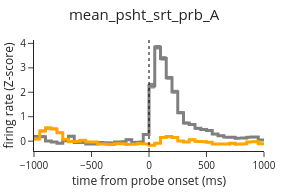

In [78]:
title = 'mean_psht_srt_prb_A'
to_pool = tosort.sort_values(by=['prb_A'],ascending=[False]).reset_index(drop=True)

pooled_PSHTs = pool_top_PSTH(to_pool, top_n=1000)
fig = plot_mean_pooled_PSTH(pooled_PSHTs)

fig.update_layout(title=dict(text=title, font_size=15, x=0.5))

filename = fig_folder / title
fig.write_image(filename.with_suffix('.png'))
fig.write_image(filename.with_suffix('.svg'))
print('done saving figures')

img_bytes = fig.to_image(format="png", width=pwidth, height=pheight)
Image(img_bytes)

### sort by early anticorrelation alone
The effect is clear, but you can also see there is anticorrelation in the late part of the context
i.e. the green line is on top of the gray right until the probe onset

done saving figures


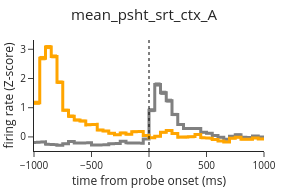

In [79]:
title = 'mean_psht_srt_ctx_A'
to_pool = tosort.sort_values(by=['ctx_A'],ascending=[True]).reset_index(drop=True)

pooled_PSHTs = pool_top_PSTH(to_pool, top_n=1000)
fig = plot_mean_pooled_PSTH(pooled_PSHTs)

fig.update_layout(title=dict(text=title, font_size=15, x=0.5))

filename = fig_folder / title
fig.write_image(filename.with_suffix('.png'))
fig.write_image(filename.with_suffix('.svg'))
print('done saving figures')

img_bytes = fig.to_image(format="png", width=pwidth, height=pheight)
Image(img_bytes)

### sort by late correlation alone
These contextual effects are less ipressive, and again this undermines the expectation of
an early anticorrelation. here we se possitive correlation with both ealry and late context
periods

done saving figures


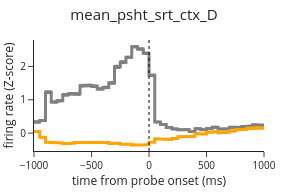

In [80]:
title = 'mean_psht_srt_ctx_D'
to_pool = tosort.sort_values(by=['ctx_D'],ascending=[False]).reset_index(drop=True)

pooled_PSHTs = pool_top_PSTH(to_pool, top_n=1000)
fig = plot_mean_pooled_PSTH(pooled_PSHTs)

fig.update_layout(title=dict(text=title, font_size=15, x=0.5))

filename = fig_folder / title
fig.write_image(filename.with_suffix('.png'))
fig.write_image(filename.with_suffix('.svg'))
print('done saving figures')

img_bytes = fig.to_image(format="png", width=pwidth, height=pheight)
Image(img_bytes)

### what if we enforce the anti and correlations?
#### first sorting by the late correaltio

done saving figures


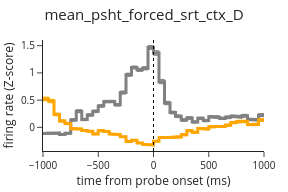

In [81]:
title = 'mean_psht_forced_srt_ctx_D'
to_pool = tosort.query(
    "ctx_A < 0 and ctx_D > 0"
).sort_values(by=['ctx_D', 'ctx_A'],ascending=[False, True]).reset_index(drop=True)

pooled_PSHTs = pool_top_PSTH(to_pool, top_n=1000)
fig = plot_mean_pooled_PSTH(pooled_PSHTs)

fig.update_layout(title=dict(text=title, font_size=15, x=0.5))

filename = fig_folder / title
fig.write_image(filename.with_suffix('.png'))
fig.write_image(filename.with_suffix('.svg'))
print('done saving figures')

img_bytes = fig.to_image(format="png", width=pwidth, height=pheight)
Image(img_bytes)

#### second, sorting by the early anticorrelation

done saving figures


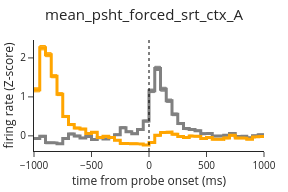

In [82]:
title = 'mean_psht_forced_srt_ctx_A'
to_pool = tosort.query(
    "ctx_A < 0 and ctx_D > 0"
).sort_values(by=['ctx_A', 'ctx_D'],ascending=[True, False]).reset_index(drop=True)

pooled_PSHTs = pool_top_PSTH(to_pool, top_n=1000)
fig = plot_mean_pooled_PSTH(pooled_PSHTs)

fig.update_layout(title=dict(text=title, font_size=15, x=0.5))

filename = fig_folder / title
fig.write_image(filename.with_suffix('.png'))
fig.write_image(filename.with_suffix('.svg'))
print('done saving figures')

img_bytes = fig.to_image(format="png", width=pwidth, height=pheight)
Image(img_bytes)

In [47]:
i = 0
fig = plot_raw_pair(cellid=to_pool.iloc[0].id,
                    contexts=[int(s) for s in to_pool.iloc[0].context_pair.split('_')],
                    probe=to_pool.iloc[0].probe, raster_fs=20,
                    colors=TENCOLOR)
fig.show()

# firing rate regression for individual neurons
this is somewhat more complicated. I try to regress the firign rate of a single neuron as a function of the firing
rate of all other neurons in the site.
There is multiple alternatives on how to treat the population firing rate:
1. take the mean of pop firing rates
2. take the mean of pop delta firing rates
3. do PCA over the pop firing rates
4. do the PCA over the delta firing rates.
plot example neuron

In [ ]:
def  get_site_neu_reg_df(cellid, dim_red):
    """
    This function takes the firing rate, or delta firing rate of all other neurons in the site,
    and reducese its dimensionality trough mean or PCA of the firing rate (preffered) or delta firing rate
    we thus create a population wide regressor for the firing rate of one neuron.

    """
    # dimensionality reduction, multiple alternatives.
    # rregressors: all other neurons in the site
    try:
        del(x); del(y)
    except:
        pass
    if dim_red == 'pca_fr':

        X = DF_fr.query(f"part == 'context' and  site == '{cellid.split('-')[0]}' and id != '{cellid}'"
                        ).pivot_table(index=['chunk', 'probe', 'context'], columns=['id'],
                                      values='value', aggfunc='first')
        PC1 = PCA(n_components=1).fit_transform(X.values)
        X = pd.Series(index=X.index, data=PC1[:, 0]
                      ).reset_index().pivot_table(index=['chunk', 'probe'], columns='context', values=0,
                                                  aggfunc='first')

        # Calculate delta firing rate
        n_comb = int(factorial(X.shape[1]) /
                     (2 * factorial(X.shape[1] - 2)))
        ctx_pair_R = np.full((X.shape[0], n_comb), np.nan)
        new_cols = list()
        for pr_idx, (c0, c1) in enumerate(itt.combinations(X.columns, r=2)):
            new_cols.append(f'{c0:02}_{c1:02}')
            ctx_pair_R[:, pr_idx] = np.abs(X.values[:, c0] - X.values[:, c1])

        X = pd.DataFrame(index=X.index, columns=new_cols, data=ctx_pair_R
                         ).melt(var_name='context_pair', value_name='delta_fr', ignore_index=False).dropna().reset_index()

        X = X.pivot_table(index=['probe', 'context_pair'], columns='chunk', values='delta_fr',
                          aggfunc='first').reset_index()

    elif dim_red in ['abs_mean_dfr', 'pca_dfr']:
        X = DF_dfr.query(f"site == '{cellid.split('-')[0]}' and id != '{cellid}' and part == 'context'")
        X = X.pivot_table(index=['id'], columns=['context_pair', 'probe', 'chunk'], values='delta_fr', aggfunc='first')

        if dim_red == 'abs_mean_dfr':
            # Take mean of aboslute value
            X = X.apply(lambda x: np.mean(np.absolute(x)), axis=0).reset_index()
        elif dim_red == 'pca_dfr':
            # pca of delta firing rates
            Xt = PCA(n_components=1).fit_transform(X=X.values.T)
            X = pd.Series(index=X.columns, data=Xt[:, 0]).reset_index()
        else:
            assert False

        X = X.pivot_table(index=['context_pair', 'probe'], columns='chunk', values=0).reset_index()
    else:
        assert False

    # regressand: the selected neuron at the selected time point
    Y = DF_dfr.query(f"id == '{cellid}' and part == 'probe'")
    Y = Y.pivot_table(index=['context_pair', 'probe'], columns='chunk', values='delta_fr', aggfunc='first'
                      ).reset_index()

    toregress = pd.merge(X, Y, on=['context_pair', 'probe'], validate='1:1')

    return toregress

### pca_fr vs pca_dfr
seems like the results from  pca over the raw firing rate or the paired firing rate difference are
justiffied in their similarity

In [ ]:
aaa = get_site_neu_reg_df('TNC014a-22-2', 'pca_fr')
bbb = get_site_neu_reg_df('TNC014a-22-2', 'pca_dfr')

mmm = pd.merge(aaa ,bbb, on=['context_pair','probe'])
aaa = mmm.loc[:, [col for col in mmm.columns if col[-1] == 'x']].values.flatten()
bbb = mmm.loc[:, [col for col in mmm.columns if col[-1] == 'y']].values.flatten()
fig = px.scatter(x=aaa, y=bbb)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

In [ ]:
toregress = get_site_neu_reg_df('TNC014a-22-2', 'pca_fr')
toregress.drop(['full_x', 'full_y'], axis=1, inplace=True)
res_dict = dict() # todo, what is important to keep??
subtitles = dict()
fig = make_subplots(4, 4, shared_xaxes='all', shared_yaxes='all',
                    subplot_titles=[f"{CC}_{PC}" for PC, CC in itt.product(['A','B','C','D'], repeat=2)])

for pc, prb_chunk in enumerate([ss for ss in toregress.columns if '_y' in ss]):
    # run regression
    X = toregress.loc[:,['A_x', 'B_x', 'C_x', 'D_x']].astype(float)
    X = sm.add_constant(X)
    Y = toregress[prb_chunk].astype(float)
    model = sm.OLS(Y, X, hasconst=True)
    res = model.fit()
    res_dict[prb_chunk] = res

    for cc, ctx_chunk in enumerate([ss for ss in toregress.columns if '_x' in ss]):

        color = ColorList[cc%len(ColorList)]

        x = toregress[ctx_chunk].values
        y = toregress[prb_chunk].values

        # decimated scatterplot
        # xm, ym = get_quantile_means(x=x, y=y, n_quantiles=1000)
        xm, ym = x, y
        fig.add_trace(go.Scatter(x=xm, y=ym, mode='markers',
                                 marker=dict(opacity=1,
                                             color=color,
                                             size=2),
                                 showlegend=False), row=pc+1, col=cc+1)



        # regression line
        xr = np.asarray([np.nanmin(xm), np.nanmax(xm)]).squeeze().astype(float)
        yr = res.params['const'] + xr * res.params[ctx_chunk]
        fig.add_trace(go.Scatter(x=xr, y=yr, mode='lines',
                                 line=dict(width=2,
                                           color=color,
                                           dash='dot'),
                                 showlegend=False), row=pc+1, col=cc+1)


        # saves subplot title
        locstr = f"{ctx_chunk.split('_')[0]}_{prb_chunk.split('_')[0]}"
        name = f"{locstr}<br>b={res.params['const']:.2f}, m={res.params[ctx_chunk]:2f}, r2={res.rsquared:.2f}"
        subtitles[locstr] = name

fig.update_layout(showlegend=False)
# names = {'Plot 1':'2016', 'Plot 2':'2017', 'Plot 3':'2018', 'Plot 4':'2019'}
fig.for_each_annotation(lambda a: a.update(text = subtitles[a.text]))

# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=1000)
Image(img_bytes)

### get the regression df parameters for all neurons D:

In [ ]:
recacheDF = False
full_reg_df_file = pl.Path(config['paths']['analysis_cache']) / f'220428_pop_to_neu_dfr_reg'
full_reg_df_file.parent.mkdir(parents=True, exist_ok=True)
if full_reg_df_file.exists() and not recacheDF:
    full_toregress = jl.load(full_reg_df_file)
else:
    full_toregress = list()
    for cellid in tqdm(DF_dfr.id.unique()):
        d = get_site_neu_reg_df(cellid, 'pca_fr')
        d['id'] = cellid
        full_toregress.append(d)

    full_toregress = pd.concat(full_toregress, ignore_index=True)
    jl.dump(full_toregress, full_reg_df_file)


In [ ]:
# filters instances for real significance
idx_filt = DF.query("metric == 'integral' and value > 0").drop(columns=['value','metric'])
toregress = pd.merge(full_toregress, idx_filt, on=['id', 'context_pair', 'probe'])
toregress

In [ ]:
res_dict = dict() # todo, what is important to keep??
subtitles = dict()
fig = make_subplots(4, 4, shared_xaxes='all', shared_yaxes='all',
                    subplot_titles=[f"{CC}_{PC}" for PC, CC in itt.product(['A','B','C','D'], repeat=2)])

for pc, prb_chunk in enumerate([ss for ss in toregress.columns if '_y' in ss]):
    # run regression
    X = toregress.loc[:,['A_x', 'B_x', 'C_x', 'D_x']].astype(float)
    X = sm.add_constant(X)
    Y = toregress[prb_chunk].astype(float)
    model = sm.OLS(Y, X, hasconst=True)
    res = model.fit()
    res_dict[prb_chunk] = res

    for cc, ctx_chunk in enumerate([ss for ss in toregress.columns if '_x' in ss]):

        color = ColorList[cc%len(ColorList)]

        x = toregress[ctx_chunk].values
        y = toregress[prb_chunk].values

        # decimated scatterplot
        xm, ym = get_quantile_means(x=x, y=y, n_quantiles=1000)
        # xm, ym = x, y
        fig.add_trace(go.Scatter(x=xm, y=ym, mode='markers',
                                 marker=dict(opacity=1,
                                             color=color,
                                             symbol='cross',
                                             size=5),
                                 line_width=2,
                                 showlegend=False), row=pc+1, col=cc+1)

        xr = np.asarray([np.nanmin(xm), np.nanmax(xm)]).squeeze().astype(float)
        yr = res.params['const'] + xr * res.params[ctx_chunk]

        fig.add_trace(go.Scatter(x=xr, y=yr, mode='lines',
                                 line=dict(width=2,
                                           color=color,
                                           dash='dot'),
                                 showlegend=False), row=pc+1, col=cc+1)


        # saves subplot title
        locstr = f"{ctx_chunk.split('_')[0]}_{prb_chunk.split('_')[0]}"
        name = f"{locstr}<br>b={res.params['const']:.2f}, m={res.params[ctx_chunk]:2f}, r2={res.rsquared:.2f}"
        subtitles[locstr] = name

fig.update_layout(showlegend=False)
# names = {'Plot 1':'2016', 'Plot 2':'2017', 'Plot 3':'2018', 'Plot 4':'2019'}
fig.for_each_annotation(lambda a: a.update(text = subtitles[a.text]))

# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=1000)
Image(img_bytes)

In [ ]:
print(res_dict['D_y'].summary())